# License Plate Recognition

@misc{
license-plate-recognition-rxg4e_dataset,
title = { License Plate Recognition Dataset },
type = { Open Source Dataset },
author = { Roboflow Universe Projects },
howpublished = { \url{ https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e } },
url = { https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e },
journal = { Roboflow Universe },
publisher = { Roboflow },
year = { 2024 },
month = { oct },
note = { visited on 2025-02-17 },
}

* References
    1. https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb
    2. https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#evaluating-the-model-optional

## Imports

In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.15.1')

In [3]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [5]:
%matplotlib inline
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [6]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.annotation_processor import AnnotationProcessor

## Paths Setup

In [7]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/License-Plate-Recognition-8/train/


In [8]:
cfg.OUTPUTS

{'OUPUT_DIR': 'exported_models/my_${PRETRAIN_MODEL.MODEL_NAME}', 'EXPORTER_SCRIPT': '/opt/models/research/object_detection/exporter_main_v2.py', 'CONFIG_PIPELINE_PATH': '${OUTPUTS.OUPUT_DIR}/', 'CHECKPOINT_PATH': '${OUTPUTS.OUPUT_DIR}/checkpoints/'}

In [9]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
DATASET_DIRS.mkdir(parents=True, exist_ok=True)

TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

TRAIN_ANNOT_FILE_PATH = TRAIN_DIR / cfg.DATASET.ANNOTATION_FILE_NAME
TEST_ANNOT_FILE_PATH = TEST_DIR / cfg.DATASET.ANNOTATION_FILE_NAME
VALID_ANNOT_FILE_PATH = VALIDATION_DIR / cfg.DATASET.ANNOTATION_FILE_NAME

CONFIG_PIPELINE_PATH = Path(cfg.OUTPUTS.CONFIG_PIPELINE_PATH)
PRETRAIN_MODEL_PATH  = Path(cfg.PRETRAIN_MODEL.PATH)



In [10]:
TRAIN_DIR

PosixPath('datasets/License-Plate-Recognition-8/train')

## Plot util functions

In [11]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    is_save=False,
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if is_save:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.title(image_name)
        plt.imshow(image_np_with_annotations)

## Dataset Download from Roboflow

In [12]:
if len(list(DATASET_DIRS.iterdir())) == 0:
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
    version = project.version(8)
    dataset = version.download(model_format="tensorflow")
                    

## Load images from directory

In [13]:
label_map = {
    'License_Plate':1
}

prepare_train_dataset = AnnotationProcessor(annotation_file=TRAIN_ANNOT_FILE_PATH)

train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, label_map=label_map)
# limit = 8
# train_images = train_images[:limit]
# train_bboxes = train_bboxes[:limit]
# train_class_ids = train_class_ids[:limit]

len(train_images), len(train_class_ids), len(train_bboxes)


(22, 22, 22)

In [14]:
train_bboxes

[array([[0.43229167, 0.80078125, 0.50260417, 0.890625  ],
        [0.39713542, 0.96679688, 0.44270833, 0.99902344]]),
 array([[0.76010782, 0.42424242, 0.78975741, 0.47121212],
        [0.54716981, 0.8       , 0.57412399, 0.82424242],
        [0.55525606, 0.89848485, 0.58490566, 0.91818182],
        [0.40431267, 0.59545455, 0.42587601, 0.61666667],
        [0.35579515, 0.22878788, 0.38005391, 0.26969697],
        [0.39622642, 0.39393939, 0.42048518, 0.42878788]]),
 array([[0.40924092, 0.66949153, 0.48844884, 0.79449153]]),
 array([[0.63036304, 0.47881356, 0.73267327, 0.69067797]]),
 array([[0.64453125, 0.09960938, 0.69661458, 0.14941406]]),
 array([[0.54571429, 0.24347826, 0.65142857, 0.32826087],
        [0.33428571, 0.8173913 , 0.37142857, 0.87826087],
        [0.33142857, 0.29565217, 0.36857143, 0.33695652],
        [0.29142857, 0.58478261, 0.30285714, 0.61304348]]),
 array([[0.5709571 , 0.33262712, 0.67986799, 0.56567797]]),
 array([[0.5754717 , 0.553125  , 0.71462264, 0.66875   ]])

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file=VALID_ANNOT_FILE_PATH)

valid_images, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, label_map=label_map)

len(valid_images), len(valid_class_ids), len(valid_bboxes)

(13, 13, 13)

to increase training size and get better loss, combining validation dataset with training datasets

In [16]:
train_images.extend(valid_images), train_class_ids.extend(valid_class_ids), train_bboxes.extend(valid_bboxes)
len(train_images), len(train_class_ids), len(train_bboxes)

(35, 35, 35)

### Define the category index dictionary

In [17]:
# Assign the license plate class ID
class_id = 1

# define a dictionary describing license plate class
category_index = {class_id :
{'id'  : class_id,
 'name': 'License_Plate'}
}

# Specify the number of classes that the model will predict
num_classes = 1
print(category_index[class_id])

{'id': 1, 'name': 'License_Plate'}


## Visualize the random license plate with their ground truth bounding boxes

In [18]:
total_train_imgs = len(train_images)
(total_train_imgs % 5 == 0) 
total_train_imgs//5 + 1

8

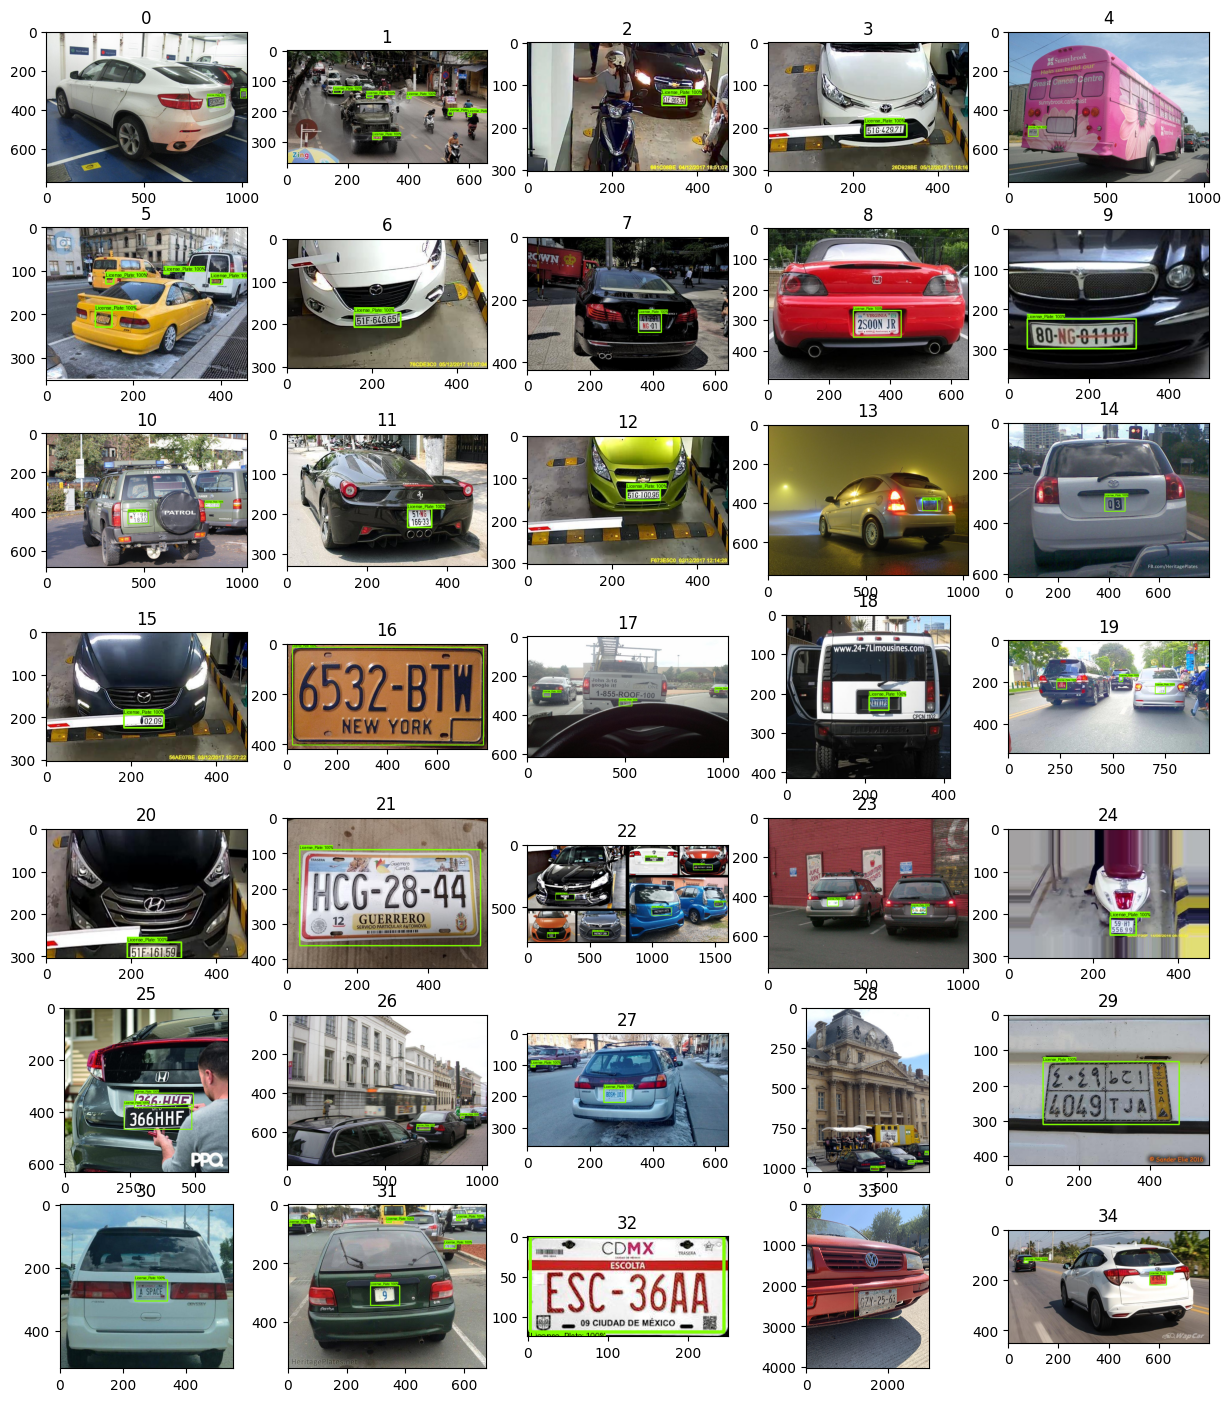

In [19]:
# give boxes a score of 100%
import random


# define the figure size
plt.figure(figsize=(15, 20))

# use the `plot_detections()` utility function to draw the ground truth boxes
random_samples = range(len(train_images))# random.sample(range(len(train_images)), 8)
# print(f"Random samples: {random_samples}")

for i, idx in enumerate(random_samples):
    plt.subplot(total_train_imgs//5 + 1, 5, i+1)
    dummy = np.ones(shape=[train_bboxes[idx].shape[0]], dtype=np.int32)
    # print(train_images[idx])
    plot_detections(
      image_np=train_images[idx],
      boxes=train_bboxes[idx],
      classes=dummy,
      scores=dummy, 
      category_index=category_index,
      image_name=f'{idx}',)

#     plt.subplots_adjust(wspace=0, hspace=0)
# plt.show()

### Data preprocessing
- Convert the class labels to one-hot representations
- convert everything (i.e. train images, gt boxes and class labels) to tensors.


In [20]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for train_image, bbox in zip(train_images, train_bboxes):
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(bbox, dtype=tf.float32))

    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[bbox.shape[0]], dtype=np.int32) - label_id_offset
    )
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

## Download the checkpoint containing the pre-trained weights for [RetinaNet](https://arxiv.org/abs/1708.02002) 

In [21]:
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
if not PRETRAIN_MODEL_PATH.exists():
    PRETRAIN_MODEL_PATH.mkdir(parents=True, exist_ok=True)

    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

    # untar (decompress) the tar file # -C /path/to/destination/folder
    !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz -C '{PRETRAIN_MODEL_PATH.parent}'

    # copy the checkpoint to the test_data folder models/research/object_detection/test_data/
    # !cp -r ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

## Configure the model

In [22]:
tf.keras.backend.clear_session()

### START CODE HERE ###
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = '/opt/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

### END CODE HERE ###
# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.0004
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.03
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
       unmatched_threshold: 0.5
       ignore_thresholds: fa

In [23]:
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

### END CODE HERE
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.0004
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.03
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.997
        scale: true
        epsilon: 0.001
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
      force_

### Modify model_config

In [24]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

### END CODE HERE

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.0004
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.03
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.997
        scale: true
        epsilon: 0.001
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
      force_m

### Saving Config

In [25]:
str(CONFIG_PIPELINE_PATH)

'exported_models/my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8'

In [26]:
config_util.save_pipeline_config(pipeline_config=model_config, directory=str(CONFIG_PIPELINE_PATH))

## Build the model

### Build the custom model

In [27]:
model = model_builder.build(model_config=model_config,is_training=True)

In [28]:
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
   _base_tower_layers_for_heads = model._box_predictor._base_tower_layers_for_heads,
   _box_prediction_head = model._box_predictor._box_prediction_head
)

### Define the temporary model checkpoint

In [29]:
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint (
    _feature_extractor=model._feature_extractor,
    _box_predictor = tmp_box_predictor_checkpoint
)
checkpoint_path =  str(PRETRAIN_MODEL_PATH / 'checkpoint/ckpt-0')

# Define a checkpoint that sets `model` to the temporary model checkpoint
checkpoint = tf.train.Checkpoint(
    model=tmp_model_checkpoint
)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(save_path=checkpoint_path)

In [30]:
# Run a dummy image to generate the model variables
# use the detection model's `preprocess()` method and pass a dummy image
dummy_img = tf.zeros([1,640,640,3])
tmp_image, tmp_shapes = model.preprocess(dummy_img)

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = model.postprocess(tmp_prediction_dict, tmp_shapes)


## Model Training

### Choose the layers to fine-tune

In [31]:
# Inspect the layers of detection_model
for i,v in enumerate(model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

In [32]:
len(model.trainable_variables) //5

53

In [33]:
# Select the prediction layer variables

# define a list that contains the layers that you wish to fine tune
last_tune_layer=len(model.trainable_variables) //5 #30
to_fine_tune = [model.trainable_variables[layer_num] for layer_num in range(last_tune_layer)]

# to_fine_tune = [
# model.trainable_variables[0],
# model.trainable_variables[1],
# model.trainable_variables[2],
# model.trainable_variables[3],
# model.trainable_variables[4],
# ]
print(to_fine_tune[0].name)
print(to_fine_tune[last_tune_layer-1].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/ClassPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0


### Training loop for the model training

In [34]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

# Use .preprocess to preprocess an image
g_preprocessed_image = model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


pre-process each image and save their outputs into two separate lists
- One list of the preprocessed images
- One list of the true shape for each preprocessed ima

In [35]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


#### Make a prediction

In [36]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [37]:
# Make predictions on the images
prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


#### Calculate loss
```
def loss(self, prediction_dict, true_image_shapes, scope=None):
```

In [38]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

# Calculate the loss after you've provided the ground truth
losses_dict = model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.37900713
classification loss 1.10095298


In [39]:
# reset the model 
model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

## Define the training step

### Set training hyperparameters

In [40]:
tf.keras.backend.set_learning_phase(True)

# set the batch_size
batch_size = 12

# set the number of batches
EPOCHS = 200

# Set the learning rate
# learning_rate =0.008 #0.0001#0.0008

# # set the optimizer and pass in the learning_rate
learning_rate = 0.005
decay_steps = 50
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, 
    momentum=0.9,
)
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)



/opt/.venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [41]:
# decorate with @tf.function for faster training 
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune, 
                ):

    with tf.GradientTape() as tape:
        preprocessed_image_list = []
        true_shape_list = []

        # Preprocess the images
        for img in image_list:
          processed_img, true_shape = model.preprocess(img)
          preprocessed_image_list.append(processed_img)
          true_shape_list.append(true_shape)
   
        preprocessed_image_tensor =  tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Provide the ground truth to the model
        model.provide_groundtruth(
                    groundtruth_boxes_list=groundtruth_boxes_list,
                    groundtruth_classes_list=groundtruth_classes_list)
        
        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
            
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        

        # Optimize the model's selected variables
        clipped_gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, vars_to_fine_tune))


    return total_loss

### Run the training loop

In [ ]:
from tqdm.notebook import tqdm, trange
# Presentation
epochs = trange(
    EPOCHS,
    desc="Epoch",
    unit="Epoch",
    postfix="loss = {loss:.4f}, lr = {lr:.4f}")
    
epochs.set_postfix(loss=0, lr=0)

with mlflow.start_run():
    mlflow.log_param("lr", learning_rate)
    mlflow.log_param("batch_size",batch_size)
    mlflow.log_param("EPOCHS",EPOCHS)
    mlflow.log_param("optimizer", optimizer.get_config())

    print('Start fine-tuning!', flush=True)
    train_loss_results = []
    for _epoch in epochs:
        # Grab keys for a random subset of examples
        all_keys = list(range(len(train_images)))
        random.shuffle(all_keys) 
        example_keys = all_keys[:batch_size]

        # Get the ground truth
        gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
        gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

        # get the images
        image_tensors = [train_image_tensors[key] for key in example_keys]

        # Training step (forward pass + backwards pass)
        total_loss = train_step_fn(image_tensors,
                                gt_boxes_list,
                                gt_classes_list,
                                model,
                                optimizer,
                                to_fine_tune)

        # if _epoch % 5 == 0:
        # Presentation
        _loss = total_loss.numpy()
        _lr = optimizer.learning_rate.numpy()
        epochs.set_postfix(loss=_loss,
                            lr=_lr)

        train_loss_results.append(_loss)
        mlflow.log_metric("loss", _loss, step=_epoch)
        mlflow.log_metric("lr", _lr, step=_epoch)

        # Update learning rate.
        # current_learning_rate = lr_schedule(_epoch)
        # optimizer.learning_rate.assign(current_learning_rate)
    print('Done fine-tuning!')

Epoch:   0%|          | 0/200 [00:00<?, ?Epoch/s, loss = {loss:.4f}, lr = {lr:.4f}]

Start fine-tuning!


I0000 00:00:1740408557.537251   63507 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


batch 0 of 150, loss=1.3179475
batch 10 of 150, loss=1.8767126
batch 20 of 150, loss=0.7498219
batch 30 of 150, loss=0.47309864
batch 40 of 150, loss=0.283122
batch 50 of 150, loss=0.21873556
batch 60 of 150, loss=0.1488738
batch 70 of 150, loss=0.13713343
batch 80 of 150, loss=0.12227633
batch 90 of 150, loss=0.10250672
batch 100 of 150, loss=0.08533072
batch 110 of 150, loss=0.07828214
batch 120 of 150, loss=0.071007706
batch 130 of 150, loss=0.07894869
batch 140 of 150, loss=0.06765614

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.title('Training Metrics')

plt.ylabel("Loss", fontsize=14)
plt.plot(train_loss_results)
plt.xlabel("Epoch", fontsize=14)
plt.show() 

## Preprocess, predict, and post process Test images

In [ ]:
## Load test images and run inference with new model!
prepared_test_images = []
# test_images, test_class_ids, test_bboxes 
for img in test_images:
    prepared_test_images.append(np.expand_dims(img, axis=0))

len(prepared_test_images)

In [ ]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = model.preprocess(input_tensor)
    prediction_dict = model.predict(preprocessed_image, shapes)

    # use the detection model's postprocess() method to get the the final detections
    detections = model.postprocess(prediction_dict, shapes)

    return detections

In [ ]:
# random_samples = random.sample(range(len(prepared_test_images)), 4)
# random_samples
len(prepared_test_images[:4])

In [ ]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(prepared_test_images[:4])):
    input_tensor = tf.convert_to_tensor(prepared_test_images[i], dtype=tf.float32)
    detections = detect(input_tensor)
    print(detections['detection_scores'][0].numpy())
    plot_detections(
      prepared_test_images[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, 
      figsize=(15, 20))
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [ ]:
detections['detection_scores'][0].numpy().max()

In [ ]:
print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

## Loading Testing Images

In [ ]:
prepare_test_dataset = AnnotationProcessor(annotation_file=TEST_ANNOT_FILE_PATH)

test_images, test_class_ids, test_bboxes  = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, label_map=label_map)

len(test_images), len(test_class_ids), len(test_bboxes)


In [ ]:
total_test_imgs= len(prepared_test_images)
total_test_imgs

In [ ]:
# define the figure size
plt.figure(figsize=(15, 20))
for i in range(total_test_imgs):
    plt.subplot(5, 3, i+1)
    input_tensor = tf.convert_to_tensor(prepared_test_images[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      prepared_test_images[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))
plt.show()  

In [ ]:
print("Inference results:",  detections['detection_boxes'][0].numpy())

## Save The trained model

### Freezing the Graph

### Path Preparation

In [ ]:
OUTPUTS_DIRS = Path(cfg.OUTPUTS.OUPUT_DIR)
EXPORTER_SCRIPT = Path(cfg.OUTPUTS.EXPORTER_SCRIPT)

CHECKPOINT_PATH = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH


In [ ]:
model.save('main_model.keras')

In [ ]:
tf.keras.Model.save(model, f'my_model.keras')

In [ ]:
ckpt_obj   = tf.train.Checkpoint(optimizer=optimizer, model=model)
ckpt_obj.save(file_prefix=f'{CHECKPOINT_PATH}/')

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None, 640, 640, 3], dtype=tf.float32)])
def detect_fn(input_tensor):
    preprocessed_image, shapes = model.preprocess(input_tensor)
    prediction_dict = model.predict(preprocessed_image, shapes)

    # use the detection model's postprocess() method to get the the final detections
    detections = model.postprocess(prediction_dict, shapes)
    return detections
# Save with signatures
tf.saved_model.save(model, f'{OUTPUTS_DIRS}', signatures={"serving_default": detect_fn})

In [ ]:
# Load the exported model
loaded_model = tf.saved_model.load(f'{OUTPUTS_DIRS}')

# Perform inference
input_tensor = tf.random.uniform([1, 640, 640, 3])  # Example input tensor
loaded_mdl_detections = loaded_model.signatures["serving_default"](input_tensor)

In [ ]:
import cv2
total_test_imgs= len(prepared_test_images)
total_test_imgs

In [ ]:
prepared_test_images[2]

In [ ]:
resize_img = cv2.resize(prepared_test_images[2][0], dsize=(640,640))
resize_img = np.expand_dims(resize_img, axis=0)
input_tensor = tf.convert_to_tensor(resize_img, dtype=tf.float32)
# _detections = loaded_model.signatures["serving_default"](input_tensor)
# input_tensor = tf.convert_to_tensor(resize_img, dtype=tf.float32)
_detections = loaded_model.signatures["serving_default"](input_tensor)
_detections['detection_boxes']

In [ ]:
    plot_detections(
      image_np=train_images[idx],
      boxes=train_bboxes[idx],
      classes=dummy,
      scores=dummy, 
      category_index=category_index,
      image_name=f'{idx}',)


In [ ]:
plt.figure(figsize=(15, 20))
for i in range(total_test_imgs):
    plt.subplot(5, 3, i+1)
    resize_img = cv2.resize(prepared_test_images[i][0], dsize=(640,640))
    resize_img = np.expand_dims(resize_img, axis=0)
    input_tensor = tf.convert_to_tensor(resize_img, dtype=tf.float32)
    _detections = loaded_model.signatures["serving_default"](input_tensor)
    plot_detections(
      image_np=prepared_test_images[i][0],
      boxes=_detections['detection_boxes'][0].numpy(),
      classes=_detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
      scores=_detections['detection_scores'][0].numpy(),
      category_index=category_index, figsize=(15, 20))
